In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#lstm库
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.layers import Bidirectional, LSTM, Dense
#arima库
import tensorflow as tf
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
import akshare as ak


In [2]:
security ="000001"
begin_date ='20131231'
end_date = '20231231'


df = ak.index_zh_a_hist(symbol =security,period='daily',start_date=begin_date,end_date= end_date)
df=df[['日期','开盘', '收盘', '最低','最高' , '成交量']]
df['日期'] = pd.to_datetime(df['日期'])
df['时间戳'] = df['日期'].apply(lambda x: x.timestamp())
day=df.shape[0]



In [3]:
#arima处理


train_len = int(day * 0.9)
ARIMA_Train = df['收盘'][0:train_len]
ARIMA_Test =  df['收盘'][train_len:]

In [4]:
# fit
model = ARIMA(ARIMA_Train, order = (7,1,1))
fit = model.fit()

#预测全部和预测测试集
preds = fit.predict(1,len(df),typ='levels')
testpreds = fit.predict(train_len+1,len(df),typ='levels')

preds_pd = preds.to_frame()
testpreds_pd = testpreds.to_frame()

preds_pd.index -= 1
testpreds_pd.index-=1
ARIMA_Result =  pd.DataFrame(columns=['raw', 'predicted', 'residuals'])
ARIMA_Result['raw'] = df['收盘']
ARIMA_Result['predicted'] = preds_pd
# 取残差
ARIMA_Result['residuals'] = ARIMA_Result['raw'] - ARIMA_Result['predicted']


In [5]:
#殘差交給lstm訓練

x=  df[['开盘', '收盘', '最低','最高' , '成交量']]
y = ARIMA_Result['residuals']

# 数据归一化
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(x)
y_scaled = scaler.fit_transform(y.values.reshape(-1, 1))

# 找到分割索引，将数据分为训练集和测试集
split_index = int(len(X_scaled) * 0.9)  # 90% 的数据用于训练，10% 的数据用于测试

X_train = X_scaled[:split_index]
X_test = X_scaled[split_index:]
y_train = y_scaled[:split_index]
y_test = y_scaled[split_index:]
# 转换数据形状以适应LSTM模型 (样本数, 时间步数, 特征数)
n_steps = 1 
n_features = X_train.shape[1]
X_train_reshaped = X_train.reshape((X_train.shape[0], n_steps, n_features))
X_test_reshaped = X_test.reshape((X_test.shape[0], n_steps, n_features))

data = {'layer1': 259, 'layer2': 410, 'layer3': 473, 'epochs': 7}

In [6]:
# 定义LSTM模型
model = Sequential()
model.add(Bidirectional(LSTM(data['layer1'], activation='relu', return_sequences=True), input_shape=(n_steps, n_features)))
model.add(Bidirectional(LSTM(data['layer2'], activation='relu', return_sequences=True)))
model.add(Bidirectional(LSTM(data['layer3'], activation='relu',return_sequences=False)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# 训练模型
model.fit(X_train_reshaped, y_train, epochs=data['epochs'], batch_size=128)
y_pred_scaled = model.predict(X_test_reshaped)

y_pred = scaler.inverse_transform(y_pred_scaled)

# 将 y_test 转换为原始范围
y_test_original = scaler.inverse_transform(y_test)



C:\Users\user\anaconda3\lib\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/7
18/18 ━━━━━━━━━━━━━━━━━━━━ 12s 102ms/step - loss: 0.1028
Epoch 2/7
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - loss: 0.0097
Epoch 3/7
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - loss: 0.0031
Epoch 4/7
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - loss: 9.2629e-04
Epoch 5/7
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - loss: 3.6572e-04
Epoch 6/7
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - loss: 2.5524e-04
Epoch 7/7
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - loss: 2.2657e-04
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step


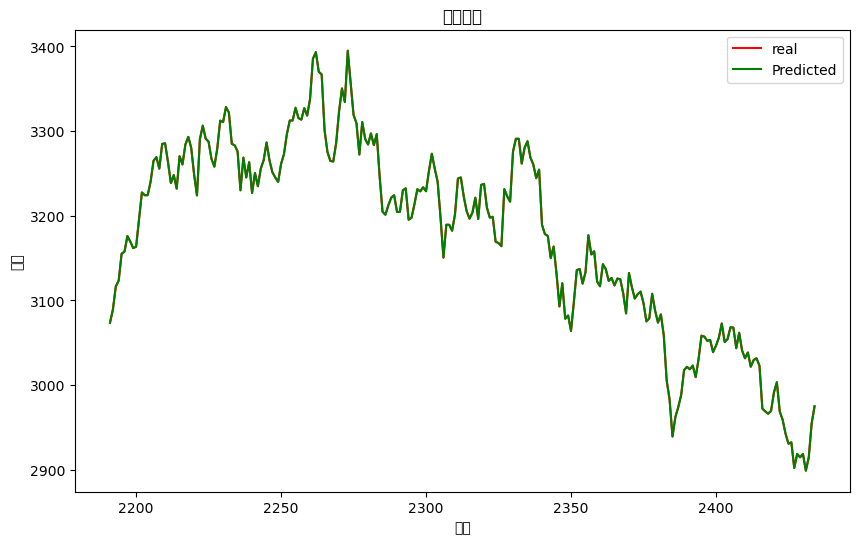

In [13]:
#lstm殘差加上arima趋势
final_pre=y_test_original+testpreds_pd
plt.figure(figsize=(10, 6))
plt.plot(df['收盘'][split_index:], color = 'red', label = 'real')
plt.plot(final_pre, color = 'green', label = 'Predicted')
plt.title('指数预测')

plt.xlabel('日期')
plt.ylabel('收盘')
plt.legend()
plt.show()